# FEMM_to_LTspice Jupyter Notebook


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import femm

import ltspice
import xml.etree.ElementTree as ET

import os
import datetime
import subprocess

Matplotlib is building the font cache; this may take a moment.


# FEMM


In [3]:
# FEMM

# Path to the FEMM installation directory
femm_path = r'C:\femm42'  # Modify this path to match your FEMM installation directory
# femm_path = r'C:\Program Files\femm42'  # Modify this path to match your FEMM installation directory

# Append the FEMM path to the PATH environment variable
os.environ['PATH'] += os.pathsep + femm_path

# Verify the PATH update
# print(os.environ['PATH'])

In [13]:
# At this point you can choose:
# 1 - to load an exciting model of FEMM (skip down to the right cell) 
# 2 - or Create a new model in FEMM (stay here and continue)

# Open FEMM and create a new magnetostatic problem
femm.openfemm()
femm.newdocument(0) # 0 for magnetic problem

# Define problem
# mi_probdef(freq[Hz],units,type,precision,depth,minangle,(acsolver))
# DC - for faster results (Debug - toggle comment to switch AC/DC):

# femm.mi_probdef(0, "millimeters", "planar", 1e-8, 12.7, 30) # DC freq=0
femm.mi_probdef(10e+3, "millimeters", "planar", 1e-8, 12.7, 30) # AC 10kHz

# Minimize FEMM GUI manually 

In [15]:
# Define materials
femm.mi_getmaterial('Air')
femm.mi_getmaterial('10 AWG')

# Add a new non-linear material defined by B-H curve (data points)
# Read the B-H curve data from a .dat file
data_Ferrite_N87_BH_Curve = np.loadtxt('Ferrite_N87_BH_Curve.dat')
B_values = data_Ferrite_N87_BH_Curve[:, 0]  # First column (B values)
H_values = data_Ferrite_N87_BH_Curve[:, 1]  # Second column (H values)
# Assain manualy option (May NOT work):
# B_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]        # T
# H_values = [0, 1000, 2000, 3000, 4000, 5000]  # A/m

# Define the non-linear material with the B-H curve
material_name = "Ferrite_N87"
femm.mi_addmaterial(material_name,
                    1,               # Relative permeability in the x direction (optional) - mu_r,x
                    1,               # Relative permeability in the y direction (optional) - mu_r,y
                    0.35,            # H_c Coercivity (S/m)
                    0,               # Source Current Density - J 
                    0.0001,          # Electrical Conductivity - Sigma
                    0,               # Lam_thickness
                    0,               # Lam_fill
                    1)               # Lam_type (default value)

# Add B-H curve data points
for B, H in zip(B_values, H_values):
    femm.mi_addbhpoint(material_name, B, H)

# Add circuits (define coils and current value. +/- for current direction. Value in Amper. e.g. 5 means I=5A
femm.mi_addcircprop("inner_coil", 5, 1)
femm.mi_addcircprop("outter_coil", -5, 1)

In [17]:
# Toroid Inductor Geometry

# Core dimensions
D_in = 12.7      # Inner diameter in mm
# D_in = 5
D_out = 20.32    # Outer diameter in mm
h = 12.7         # Height in mm (actually set in *depth* while defining the problem at the begining ^ )
r_in = D_in / 2  # Inner radius
r_out = D_out / 2 # Outer radius

# Coil dimensions
coil_diameter = 2.588   # Diameter of 10 AWG wire (approximately 2.588 mm)
# Gap for coil dimensions (adjust as needed)
# gap_for_coil = coil_diameter + 0.1
gap_for_coil = 0.5 # smaller then whats neede just for better visuality - shouldnt influence the results? ?TODO - make sure?

In [19]:
# Drawing

# Core center
center_x = 0
center_y = 0

# Create core geometry (toroid cross-section)
# Inner
femm.mi_drawarc(center_x + r_in, center_y, center_x - r_in, center_y, 180, 1)
femm.mi_drawarc(center_x - r_in, center_y, center_x + r_in, center_y, 180, 1)
# Add gaps from inside of the core
femm.mi_drawarc(center_x + r_in - gap_for_coil, center_y, center_x - r_in + gap_for_coil, center_y, 180, 1)
femm.mi_drawarc(center_x - r_in + gap_for_coil, center_y, center_x + r_in - gap_for_coil, center_y, 180, 1)
# Outer
femm.mi_drawarc(center_x + r_out, center_y, center_x - r_out, center_y, 180, 1)
femm.mi_drawarc(center_x - r_out, center_y, center_x + r_out, center_y, 180, 1)
# Add gaps from outside of the core
femm.mi_drawarc(center_x + r_out + gap_for_coil, center_y, center_x - r_out - gap_for_coil, center_y, 180, 1)
femm.mi_drawarc(center_x - r_out - gap_for_coil, center_y, center_x + r_out + gap_for_coil, center_y, 180, 1)

# At this point you should see drawings in the GUI, open it to make sure.

In [21]:
# Assign materials
# Outter materail: Outside r_out + gap_for_coil
femm.mi_addblocklabel(center_x + r_out + gap_for_coil + 1, center_y + 5)
femm.mi_selectlabel(center_x + r_out + gap_for_coil + 1, center_y + 5)
femm.mi_setblockprop('Air', 1, 0, '', 0, 0, 0)
femm.mi_clearselected()

# Inner Material: Inside r_in - gap_for_coil
femm.mi_addblocklabel(center_x + 1, center_y + 1)
femm.mi_selectlabel(center_x + 1, center_y + 1)
femm.mi_setblockprop('Air', 1, 0, '', 0, 0, 0)
femm.mi_clearselected()

# Core Material: Between r_out and r_in
femm.mi_addblocklabel(center_x + (r_in + r_out) / 2, center_y)
femm.mi_selectlabel(center_x + (r_in + r_out) / 2, center_y)
femm.mi_setblockprop('Ferrite_N87', 1, 0, '', 0, 0, 0)
femm.mi_clearselected()

In [23]:
# Assign circuits (coil)
# Outter Circuit: Between r_out and r_out + gap_for_coil
femm.mi_addblocklabel(center_x + r_out + gap_for_coil / 2, center_y)
femm.mi_selectlabel(center_x + r_out + gap_for_coil / 2, center_y)
femm.mi_setblockprop("10 AWG", 1, 0, "outter_coil", 0, 0, 20)
femm.mi_clearselected()

# Inner Circuit: Between r_in - gap_for_coil and r_in
femm.mi_addblocklabel(center_x + r_in - gap_for_coil / 2, center_y)
femm.mi_selectlabel(center_x + r_in - gap_for_coil / 2, center_y)
femm.mi_setblockprop("10 AWG", 1, 0, "inner_coil", 0, 0, 20)
femm.mi_clearselected()

In [25]:
# Create IABC open boundary  (auto optin to creat boundry condition)
femm.mi_makeABC()

In [27]:
# Save the document - optinal - save with date and time to avoid overriding

# Get the current date and time
now = datetime.datetime.now()
# Format the date and time as a string
timestamp = now.strftime("%d%m%Y_%H%M")
# Create the filename with the timestamp
filename = f'toroid_core_geometry_{timestamp}.fem'

# Save the document with the new filename
femm.mi_saveas(filename)

# femm.mi_saveas('toroid_core_geometry.fem')
# femm.mi_saveas('toroid_core_geometry_DC.fem')
# femm.mi_saveas('toroid_core_geometry_DC_2.fem')
# femm.mi_saveas('toroid_core_geometry_laptop_test.fem')
# femm.mi_saveas('toroid_core_geometry_AC.fem')

In [29]:
# Analyze the model - may take some time, aspecialy while using frequency. Wait for the [*] on the left to be [number]
femm.mi_analyze()
femm.mi_loadsolution()

In [31]:
# Calculate the inductancy L

# Get the circuit properties
circuit_name = 'inner_coil'  # Replace with the actual circuit name
circuit_properties = femm.mo_getcircuitproperties(circuit_name)
print(circuit_properties)

current = circuit_properties[0]
flux_linkage = circuit_properties[2]

# Calculate the inductance
L = flux_linkage / current
print(f'Inductance: {L} H')

# Extract the real part and convert to microhenries
L_microhenry = L.real * 1e6
print(f'Inductance: {L_microhenry:.2f} µH')

[5, (0.4032410495956466+39.83361252847401j), (0.0006339716335113877-6.114117854996557e-06j)]
Inductance: (0.00012679432670227754-1.2228235709993114e-06j) H
Inductance: 126.79 µH


In [33]:
# Calculate the ESR (Equivalent Series Resistance) of the inductor

# Define the area for integration, where the coil goes
# This part depends on the specific model and how it is defined
femm.mo_seteditmode('area')
femm.mo_selectblock(center_x + r_out + gap_for_coil / 2, center_y)  # Replace with the coordinates of your coil area
femm.mo_selectblock(center_x + r_in - gap_for_coil / 2, center_y)

# Integrate the resistive losses
power_dissipation = femm.mo_blockintegral(4)  # Integral type 4 is for resistive losses
print(f'Power Dissipation: {power_dissipation} Watt')

# Calculate the ESR
ESR = power_dissipation / (current ** 2)
print(f'Equivalent Series Resistance (ESR): {ESR} Ω')

# convert to mili oham
ESR_mili = ESR.real * 1e3
print(f'ESR: {ESR_mili:.4f} mΩ')

Power Dissipation: 0.03904977484928465 Watt
Equivalent Series Resistance (ESR): 0.0015619909939713862 Ω
ESR: 1.5620 mΩ


# FEMM - Use an existing file


In [37]:
# Use an existing file
# CHANGE PATH

femm.openfemm()
# Open an existing FEMM file
# fem_file_path = r'C:\Users\xzami\anaconda3\project_femm_to_spice\toroid_core_geometry_V0.fem'  # Replace with the path to your .fem file
fem_file_path = r'C:\Users\PEARLLAB1\anaconda3\FEMM_to_LTspice\toroid_core_geometry_28082024_1810.fem'  # Replace with the path to your .fem file
femm.opendocument(fem_file_path)
# ans_file_path = r'C:\Users\xzami\anaconda3\project_femm_to_spice\toroid_core_geometry_V0.ans'  # Replace with the path to your .fem file
ans_file_path = r'C:\Users\PEARLLAB1\anaconda3\FEMM_to_LTspice\toroid_core_geometry_28082024_1810.ans'  # Replace with the path to your .fem file
femm.opendocument(ans_file_path)

# Analyze the model
# Toggle comment to analyze - may take some time
# femm.mi_analyze()
femm.mi_loadsolution()

# Minimize FEMM GUI manually

In [39]:
# Toroid Inductor Geometry - should be changed acording to your design

# Core dimensions
D_in = 12.7      # Inner diameter in mm
# D_in = 5
D_out = 20.32    # Outer diameter in mm
h = 12.7         # Height in mm (actually set in *depth* while defining the problem at the begining ^ )
r_in = D_in / 2  # Inner radius
r_out = D_out / 2 # Outer radius

# Coil dimensions
coil_diameter = 2.588   # Diameter of 10 AWG wire (approximately 2.588 mm)
# Gap for coil dimensions (adjust as needed)
# gap_for_coil = coil_diameter + 0.1
gap_for_coil = 0.5 # smaller then whats neede just for better visuality - shouldnt influence the results? ?TODO - make sure?

# Core center
center_x = 0
center_y = 0

In [41]:
# Calculate the inductancy L

# Get the circuit properties
circuit_name = 'inner_coil'  # Replace with the actual circuit name
circuit_properties = femm.mo_getcircuitproperties(circuit_name)
print(circuit_properties)

current = circuit_properties[0]
flux_linkage = circuit_properties[2]

# Calculate the inductance
L = flux_linkage / current
print(f'Inductance: {L} H')

# Extract the real part and convert to microhenries
L_microhenry = L.real * 1e6
print(f'Inductance: {L_microhenry:.2f} µH')

# Format L_microhenry to 2 decimal places and assign to new_L_microhenry
new_L_microhenry = round(L_microhenry, 2)
# print(new_L_microhenry)


# Calculate the ESR (Equivalent Series Resistance) of the inductor

# Define the area for integration, where the coil goes
# This part depends on the specific model and how it is defined
femm.mo_seteditmode('area')
femm.mo_selectblock(center_x + r_out + gap_for_coil / 2, center_y)  # Replace with the coordinates of your coil area
femm.mo_selectblock(center_x + r_in - gap_for_coil / 2, center_y)

# Integrate the resistive losses
power_dissipation = femm.mo_blockintegral(4)  # Integral type 4 is for resistive losses
print(f'Power Dissipation: {power_dissipation} Watt')

# Calculate the ESR
ESR = power_dissipation / (current ** 2)
print(f'Equivalent Series Resistance (ESR): {ESR} Ω')

# convert to mili oham
ESR_mili = ESR.real * 1e3
print(f'ESR: {ESR_mili:.4f} mΩ')

# Format ESR_mili to 2 decimal places and assign to new_ESR_mili
new_ESR_mili = round(ESR_mili, 2)
# print(new_ESR_mili)

[5, (0.4032410495956466+39.83361252847401j), (0.0006339716335113877-6.114117854996557e-06j)]
Inductance: (0.00012679432670227754-1.2228235709993114e-06j) H
Inductance: 126.79 µH
Power Dissipation: 0.03904977484928465 Watt
Equivalent Series Resistance (ESR): 0.0015619909939713862 Ω
ESR: 1.5620 mΩ


In [43]:
# Close FEMM
femm.closefemm()

# LTspice


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# import femm

# import ltspice
# import xml.etree.ElementTree as ET

# import os
# import datetime
# import subprocess

In [51]:
# Path to the LTspice installation directory
# ltspice_path = r'C:\Program Files\ADI\LTspice'
ltspice_path = r'C:\Users\PEARLLAB1\AppData\Local\Programs\ADI\LTspice'

# Append the LTspice path to the PATH environment variable
os.environ['PATH'] += os.pathsep + ltspice_path

# Verify the PATH update
# print(os.environ['PATH'])

In [53]:
print(os.environ['PATH'])

C:\Users\PEARLLAB1\anaconda3;C:\Users\PEARLLAB1\anaconda3\Library\mingw-w64\bin;C:\Users\PEARLLAB1\anaconda3\Library\usr\bin;C:\Users\PEARLLAB1\anaconda3\Library\bin;C:\Users\PEARLLAB1\anaconda3\Scripts;C:\Users\PEARLLAB1\anaconda3\bin;C:\Users\PEARLLAB1\anaconda3\condabin;C:\Users\PEARLLAB1\anaconda3;C:\Users\PEARLLAB1\anaconda3\Library\mingw-w64\bin;C:\Users\PEARLLAB1\anaconda3\Library\usr\bin;C:\Users\PEARLLAB1\anaconda3\Library\bin;C:\Users\PEARLLAB1\anaconda3\Scripts;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\MATLAB\R2021b\runtime\win64;C:\Program Files\MATLAB\R2021b\bin;C:\Program Files\Wolfram Research\WolframScript;C:\Users\PEARLLAB1\AppData\Local\Microsoft\WindowsApps;.;C:\femm42;C:\Users\PEARLLAB1\AppData\Local\Programs\ADI\LTspice;C:\Users\PEARLLAB1\AppData\Local\Programs\ADI\LTspice


In [47]:
def open_ltspice_gui(ltspice_exe, sim_file):
    # Command to open LTspice GUI and load the specified file
    command = f'start "" "{ltspice_exe}" "{sim_file}"'
    print(f"Executing command: {command}")
    
    try:
        subprocess.run(command, shell=True)
        print("LTspice GUI opened and file loaded.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while running the simulation: {e}")

In [57]:
# Path to LTspice executable
ltspice_exe = 'LTspice.exe'

# Path to your LTspice file (.asc or .net)
# sim_file = r'C:\Users\xzami\anaconda3\project_femm_to_spice\Boost_Converter_V0.asc'
sim_file = r'C:\Users\PEARLLAB1\anaconda3\FEMM_to_LTspice\Boost_Converter_V0.asc'

In [63]:
# Call the function to open LTspice and load the file
open_ltspice_gui(ltspice_exe, sim_file)

Executing command: start "" "LTspice.exe" "C:\Users\PEARLLAB1\anaconda3\FEMM_to_LTspice\Boost_Converter_V0.asc"
LTspice GUI opened and file loaded.


In [65]:
# At this point you need to run the simulation manually throw the GUI
# in order to generate the .raw file
# or run the next cell and then close the GUI manually (and ignore the errors :) )

In [67]:
# Define the command to run LTspice with the simulation
command = [ltspice_exe, '-Run', sim_file]

# Run the command - THEN close the GUI manually!
result = subprocess.run(command, capture_output=True, text=True)

# TODO "stop" the cell
# for now close the GUI manually before proceeding

In [69]:
def load_simulation_results(sim_file):
    raw_file = sim_file.replace('.asc', '.raw')
    
    # if not os.path.exists(raw_file):
        # raise FileNotFoundError(f"The raw file '{raw_file}' does not exist.")
    
    l = ltspice.Ltspice(raw_file)
    l.parse()
    return l

In [71]:
# Load the simulation results
ltspice_data = load_simulation_results(sim_file)

In [73]:
# Get the list of available signals

signals = ltspice_data.variables
# getData()
print("Available signals:", signals)

Available signals: ['time', 'V(v_in)', 'V(n002)', 'V(v_out)', 'V(n001)', 'V(vst)', 'V(n5v)', 'V(p5v)', 'V(vc)', 'V(d)', 'V(n003)', 'I(B1)', 'Id(M2)', 'Ig(M2)', 'Is(M2)', 'I(C1)', 'I(C2)', 'I(D1)', 'I(L1)', 'I(R1)', 'I(Esr)', 'I(V1)', 'I(V2)', 'I(V3)', 'I(V4)', 'I(V5)', 'Ix(u2:IN+)', 'Ix(u2:IN-)', 'Ix(u2:POS)', 'Ix(u2:NEG)', 'Ix(u2:OUT)']


C:\Users\PEARLLAB1\AppData\Local\Temp\ipykernel_7256\323480381.py:3: DeprecationWarning: Call to deprecated method getData. (use method which follows pep8) -- Deprecated since version 1.0.0.
  voltage = ltspice_data.getData('V(v_in)')
C:\Users\PEARLLAB1\AppData\Local\Temp\ipykernel_7256\323480381.py:4: DeprecationWarning: Call to deprecated method getTime. (use method which follows pep8) -- Deprecated since version 1.0.0.
  time = ltspice_data.getTime()


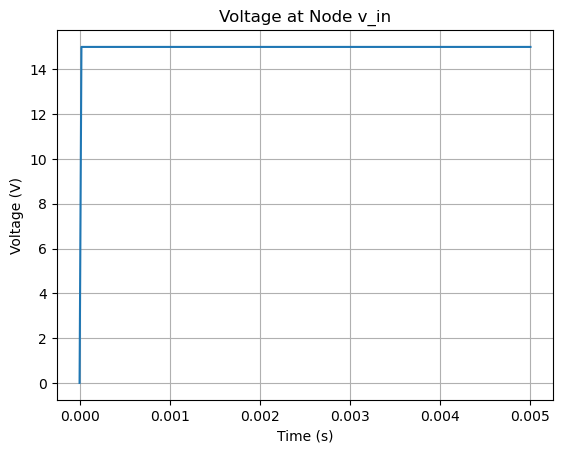

In [75]:
# Access a specific signal (e.g., V(n001))
if 'V(v_in)' in signals:
    voltage = ltspice_data.getData('V(v_in)')
    time = ltspice_data.getTime()

# Plot the results
    plt.plot(time, voltage)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Voltage at Node v_in')
    plt.grid(True)
    plt.show()
else:
    print("Signal 'V(v_in)' not found in the simulation results.")

In [77]:
# Path to your LTspice schematic file (.asc)
# asc_file = r'C:\Users\xzami\anaconda3\project_femm_to_spice\Boost_Converter_V0.asc'
asc_file = r'C:\Users\PEARLLAB1\anaconda3\FEMM_to_LTspice\Boost_Converter_V0.asc'

# Read the .asc file with a specific encoding
with open(asc_file, 'r', encoding='latin-1') as file:
    lines = file.readlines()

# Print the first few lines to understand the format
# for line in lines[:10]:
#     print(line.strip())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\xzami\\anaconda3\\project_femm_to_spice\\Boost_Converter_V0.asc'

In [ ]:
# Function to modify the inductance value of an inductor

def modify_inductance(lines, inductor_name, new_value):
    for i, line in enumerate(lines):
        if line.strip() == f"SYMATTR InstName {inductor_name}":
            if lines[i + 1].strip().startswith("SYMATTR Value"):
                # Print the original lines for verification
                print(f"Original line {i}: {lines[i].strip()}")
                print(f"Original line {i + 1}: {lines[i + 1].strip()}")
                
                # Modify the inductance value
                lines[i + 1] = f"SYMATTR Value {new_value}\n"
                
                # Print the modified lines for verification
                print(f"Modified line {i}: {lines[i].strip()}")
                print(f"Modified line {i + 1}: {lines[i + 1].strip()}")
                break
    return lines

In [ ]:
# Modify the inductance of L1 to a new value (e.g., 200uH)

# new_inductance_value = '200u'
new_inductance_value = f"{new_L_microhenry}u"

lines = modify_inductance(lines, 'L1', new_inductance_value)

# Save the modified .asc file
with open(asc_file, 'w', encoding='latin-1') as file:
    file.writelines(lines)

print("Inductance value modified successfully.")


# To see the change reload the .asc file

In [ ]:
# Function to modify the ESR value

def modify_ESR(lines, ESR_name, new_value):
    for i, line in enumerate(lines):
        if line.strip() == f"SYMATTR InstName {ESR_name}":
            if lines[i + 1].strip().startswith("SYMATTR Value"):
                # Print the original lines for verification
                print(f"Original line {i}: {lines[i].strip()}")
                print(f"Original line {i + 1}: {lines[i + 1].strip()}")
                
                # Modify the inductance value
                lines[i + 1] = f"SYMATTR Value {new_value}\n"
                
                # Print the modified lines for verification
                print(f"Modified line {i}: {lines[i].strip()}")
                print(f"Modified line {i + 1}: {lines[i + 1].strip()}")
                break
    return lines

In [ ]:
# Modify the resistance of ESR to a new value (e.g., 1.5m)

# new_ESR_value = '1.55m'
new_ESR_value = f"{new_ESR_mili}m"

lines = modify_ESR(lines, 'ESR', new_ESR_value)

# Save the modified .asc file
with open(asc_file, 'w', encoding='latin-1') as file:
    file.writelines(lines)

print("ESR value modified successfully.")


# To see the change reload the .asc file

# Open LTspice confirm the changes and run the simulation